In [1]:
import pandas as pd

def simplify(df, name, start_time):
    df_grouped = df.groupby(by=['time']).count()
    df_grouped.insert(0, "tot_subs", range(1, 1+len(df_grouped)))
    df_grouped['name'] = name
    df_grouped = df_grouped.drop(['userid'], axis=1)
    df_grouped['time'] = df_grouped.index
    df_grouped['date'] =  pd.to_datetime(df_grouped['time'], unit='s') ## pandas recognizes your format
    df_grouped['diff'] = df_grouped['time'] - start_time
    df_grouped['delta_days'] = pd.to_timedelta(df_grouped['diff'], unit='s', errors='raise').dt.days
    #df_grouped = df_grouped.sort_values(by=['time'])
    return df_grouped
#top1_grouped


def distill(src_df):
    df = src_df.groupby(by=['delta_days']).count()
    df['delta_days'] = df.index
    df['subs'] = df['tot_subs']
    df['tot_subs'] = df['subs'].cumsum()
    df = df.drop(['name', 'submission', 'time', 'date', 'diff'], axis=1)
    df = df.reset_index(drop=True)
    return df



In [2]:
# Read and inspect

df = pd.read_csv("antiphish_top_submission_timing-anon.csv", index_col = 0)


for c in df.columns:
    if c == "time":
        continue
    print("{}:\t{}".format(c,df[c].unique()))

userid:	['mlsmgfm' 'pip' 'qjykdxju' 'npttlpwx']
submission:	[ 2  1  3  5  9  4 10  6  8  7]


In [3]:
top1_name = "npttlpwx"
top2_name = "qjykdxju"
top3_name = "pip"
top4_name = "mlsmgfm"

# taken from the final results of the challenge
top1_queries = 320
top2_queries = 343
top3_queries = 608
top4_queries = 9982

top1_df = df[df['userid']==top1_name]
top2_df = df[df['userid']==top2_name]
top3_df = df[df['userid']==top3_name]
top4_df = df[df['userid']==top4_name]

start_time = 1628258400 # august 6, 2021 at midnight (https://cujo.com/machine-learning-security-evasion-competition-2021-calls-for-researchers-and-practitioners/)

print("SANITY CHECK")
print(len(top1_df), len(top2_df), len(top3_df), len(top4_df))
print(len(df), (len(top1_df)+len(top2_df)+len(top3_df)+len(top4_df)))

SANITY CHECK
22 50 54 528
654 654


In [4]:
top1_df.head()

,userid,time,submission
174,npttlpwx,1631912268,3
354,npttlpwx,1631893334,3
381,npttlpwx,1631008023,3
382,npttlpwx,1631008023,2
383,npttlpwx,1631008023,5


In [5]:
# Group
top1_grouped = simplify(top1_df, top1_name, start_time)
top2_grouped = simplify(top2_df, top2_name, start_time)
top3_grouped = simplify(top3_df, top3_name, start_time)
top4_grouped = simplify(top4_df, top4_name, start_time)

top1_grouped.head()

,tot_subs,submission,name,time,date,diff,delta_days
time,,,,,,,
1631008023,1,10,npttlpwx,1631008023,2021-09-07 09:47:03,2749623,31
1631891126,2,9,npttlpwx,1631891126,2021-09-17 15:05:26,3632726,42
1631893334,3,1,npttlpwx,1631893334,2021-09-17 15:42:14,3634934,42
1631900374,4,1,npttlpwx,1631900374,2021-09-17 17:39:34,3641974,42
1631912268,5,1,npttlpwx,1631912268,2021-09-17 20:57:48,3653868,42


In [6]:
# Distill
top1_distilled = distill(top1_grouped)
top2_distilled = distill(top2_grouped)
top3_distilled = distill(top3_grouped)
top4_distilled = distill(top4_grouped)

top1_distilled.head()

,tot_subs,delta_days,subs
0,1,31,1
1,5,42,4


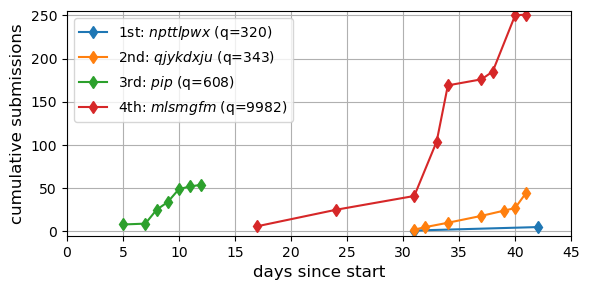

In [7]:
# Plot

ax = top1_distilled.plot(x='delta_days', marker='d', y='tot_subs', figsize=(6, 3), label='1st: ${}$ (q={})'.format(top1_name, top1_queries))
top2_distilled.plot(ax=ax, marker='d', x='delta_days', y='tot_subs', label='2nd: ${}$ (q={})'.format(top2_name, top2_queries))
top3_distilled.plot(ax=ax, marker='d', x='delta_days', y='tot_subs', label='3rd: ${}$ (q={})'.format(top3_name, top3_queries))
top4_distilled.plot(ax=ax, marker='d', x='delta_days', y='tot_subs', label='4th: ${}$ (q={})'.format(top4_name, top4_queries))
ax.grid()
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_xticks(fontsize=20)
ax.set_xlim(0, 45)
ax.set_ylim(-5, 255)
ax.set_xlabel("days since start", fontsize=12)
ax.set_ylabel("cumulative submissions", fontsize=12)
ax.figure.tight_layout()
ax.figure.savefig("results.pdf")